In [1]:
import numpy as np
import pandas as pd

from gtda.time_series import SlidingWindow
from gtda.diagrams import PersistenceLandscape
from gtda.homology import VietorisRipsPersistence

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.set_option('display.max_columns', None)
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
# !pip install spectrum 
# from spectrum.periodogram import speriodogram

import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess

from pylab import *

In [2]:
# Functions to compute the Lp norms
# Find the range of x values from the persistence diagram:
def Ftseq(diagram):
    births =[]
    deaths =[]
    for pair in diagram:
        if pair[2] == 1:
            births.append(pair[0])
            deaths.append(pair[1])
    return np.linspace(min(births), max(deaths), 100)

# Calculate Lp norm:
def Lpnorm(tseq, landscapevalues, p = 1):
    norms = []
    if p.lower() == 'auc':
        for point in zip(tseq,landscapevalues):
            norms.append(np.trapz(landscapevalues, tseq))
    else: 
        for point in zip(tseq,landscapevalues):
            norms.append(np.linalg.norm(point, p))        
    return sum(norms)

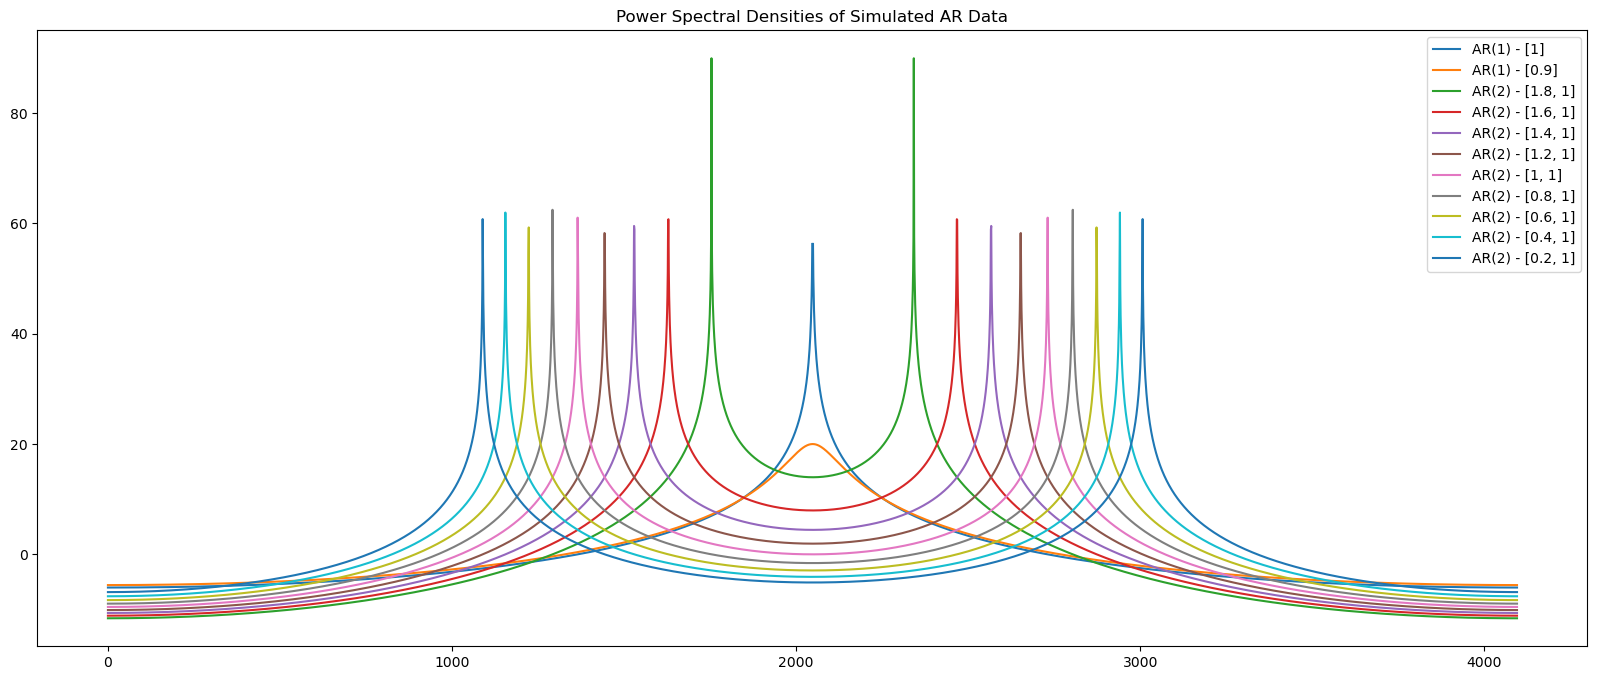

In [3]:
import spectrum.arma
from pylab import plot, log10, legend

plt.figure(figsize = (20,8), facecolor = 'white')
# plt.subplot(2,1,1)
arterms = [1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [.9]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [1.8,1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [1.6,1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [1.4,1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [1.2,1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [1,1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [.8,1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [.6,1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [.4,1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
arterms = [.2,1]
plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))

plt.title('Power Spectral Densities of Simulated AR Data')
legend()


# plt.subplot(2,1,2)
# arterms = [.5]
# plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
# arterms = [.9]
# plot(10*log10(spectrum.arma.arma2psd(arterms,None)), label= 'AR(' + str(len(arterms)) + ') - '  +str(arterms))
# plt.title('AR Power Comparison')
# legend()

## Experiment of multiple lags

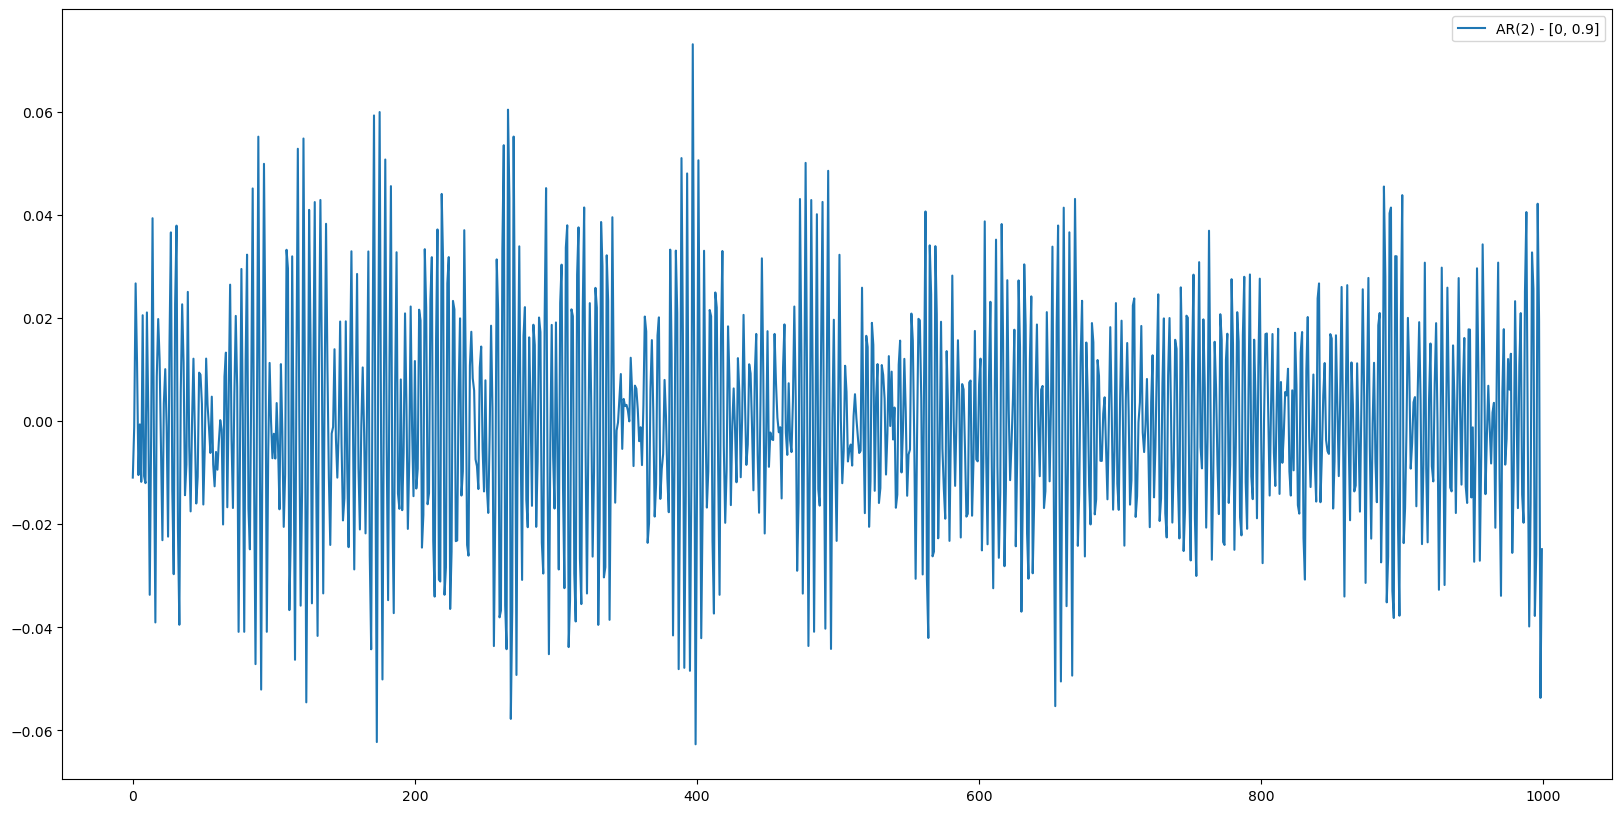

In [4]:
n = 1000
np.random.seed(1122) 
arterms1 = [0,.9]
ar = np.append([1], arterms1)
ma = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data1 = AR_object.generate_sample(nsample=n, burnin = 10000, scale = .01)
plt.figure(figsize = (20,10))
plt.plot(simulated_data1, label = 'AR(' + str(len(arterms1)) + ') - '  +str(arterms1))
legend()
plt.show()


period = 3.9840637450199203


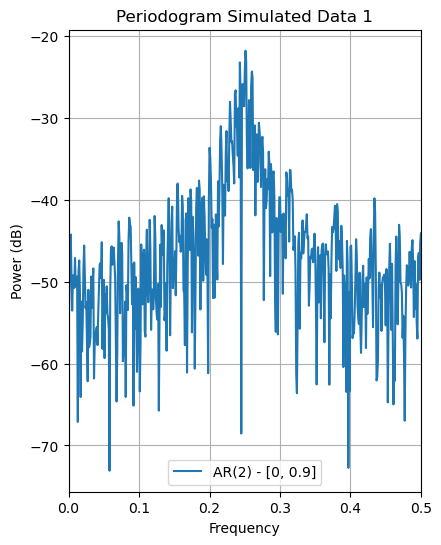

In [5]:
from spectrum import Periodogram
from spectrum import speriodogram

plt.figure(figsize = (10,6), facecolor = 'white')
plt.subplot(1,2,1)
p = Periodogram(simulated_data1
#                 , sampling=len(simulated_data1)
               )
p.run()
p.plot(sides='onesided', label = 'AR(' + str(len(arterms1)) + ') - '  +str(arterms1))
plt.title('Periodogram Simulated Data 1')
plt.legend(loc = 'lower center')


psddf = pd.DataFrame({'Frequency': p.frequencies(),
              'PSD':p.psd})
period = 1/psddf[psddf['PSD'] == psddf['PSD'].max()]['Frequency'].values[0]
print('period = ' + str(period))

In [10]:
lags =[]
Norms2 = []
for lag in range(0,25):
    simulated_data = pd.DataFrame({'Simulated Data 1' : simulated_data1
                 })
    simulated_data['Simulated Data 2'] = simulated_data['Simulated Data 1'].shift(lag)
    simulated_data = simulated_data.dropna()
    
    dataPct = simulated_data
#     dataPct = dataPct.dropna()
    # dataPct.head()

    # Create point cloud of size 60 and stride 1
    window_size = 150
    stride = 1
    df = dataPct
    X = df
    y = df.index
    SW = SlidingWindow(size=window_size, stride=stride)
    X_sw, yr = SW.fit_transform_resample(X, y)

    # Calculate the norms for each of the windows in the multivariate sliding window

    # Initialize empty list
    Norms = np.empty(window_size-1)
    Norms[:] = np.nan
    Norms = list(Norms)
    vrp = VietorisRipsPersistence()
    pl = PersistenceLandscape()
    for pointcloud in X_sw:
        persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
        landscapedata = pl.fit_transform(persistencediagram)
        tseq = Ftseq(persistencediagram[0])
        yvalues = landscapedata[0][1]
        Norms.append(Lpnorm(tseq, yvalues, p = 'auc'))

    norm2 = np.trapz(list(pd.Series(Norms).dropna()))
    Norms2.append(norm2)
    lags.append(lag)


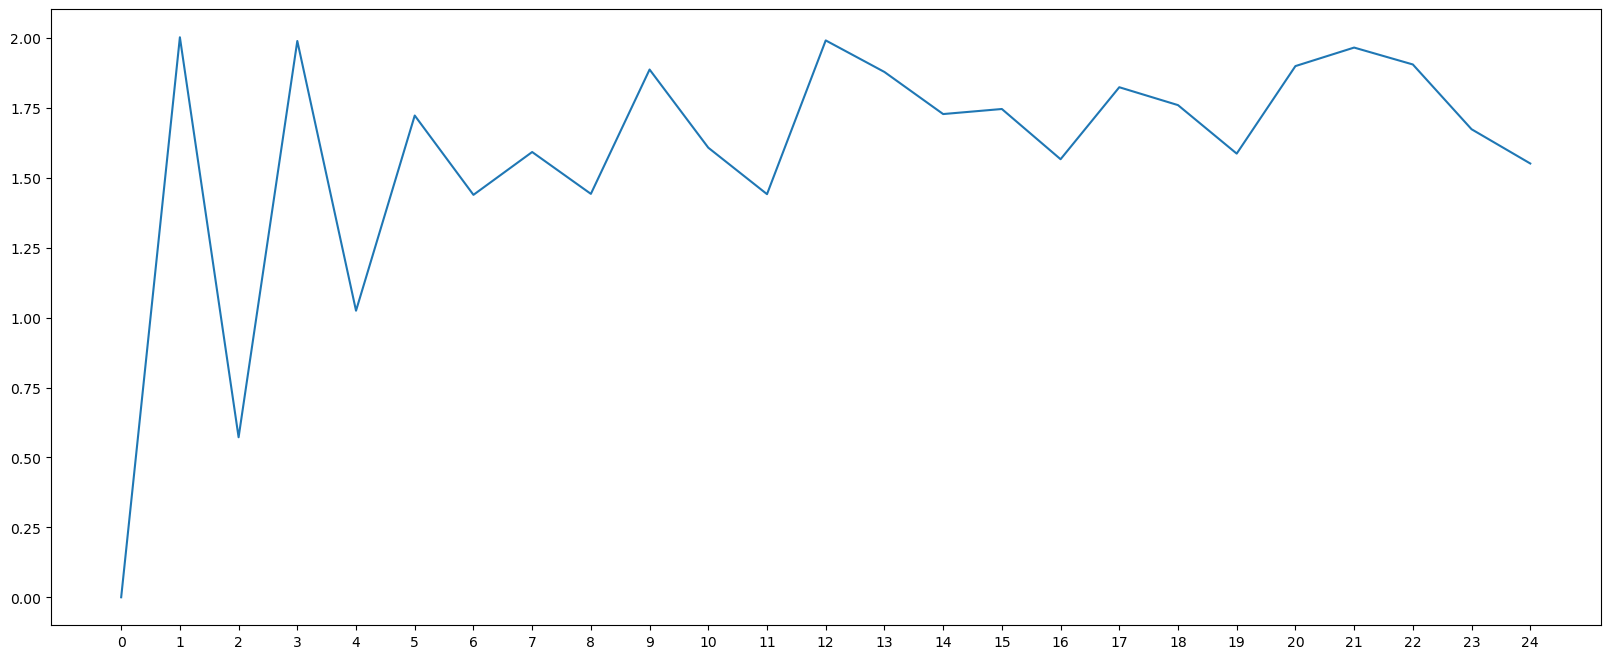

In [13]:
plt.figure(figsize = (20,8))
plt.plot(lags, Norms2)
plt.xticks(lags)
plt.show()

## On Percent Change

In [14]:
lags =[]
Norms2 = []
for lag in range(0,25):
    simulated_data = pd.DataFrame({'Simulated Data 1' : simulated_data1
                 })
    simulated_data['Simulated Data 2'] = simulated_data['Simulated Data 1'].shift(lag)
    simulated_data = simulated_data.dropna()
    
    dataPct = simulated_data.pct_change()
    dataPct = dataPct.dropna()
    # dataPct.head()

    # Create point cloud of size 60 and stride 1
    window_size = 150
    stride = 1
    df = dataPct
    X = df
    y = df.index
    SW = SlidingWindow(size=window_size, stride=stride)
    X_sw, yr = SW.fit_transform_resample(X, y)

    # Calculate the norms for each of the windows in the multivariate sliding window

    # Initialize empty list
    Norms = np.empty(window_size)
    Norms[:] = np.nan
    Norms = list(Norms)
    vrp = VietorisRipsPersistence()
    pl = PersistenceLandscape()
    for pointcloud in X_sw:
        persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
        landscapedata = pl.fit_transform(persistencediagram)
        tseq = Ftseq(persistencediagram[0])
        yvalues = landscapedata[0][1]
        Norms.append(Lpnorm(tseq, yvalues, p = 'auc'))

    norm2 = np.trapz(list(pd.Series(Norms).dropna()))
    Norms2.append(norm2)
    lags.append(lag)


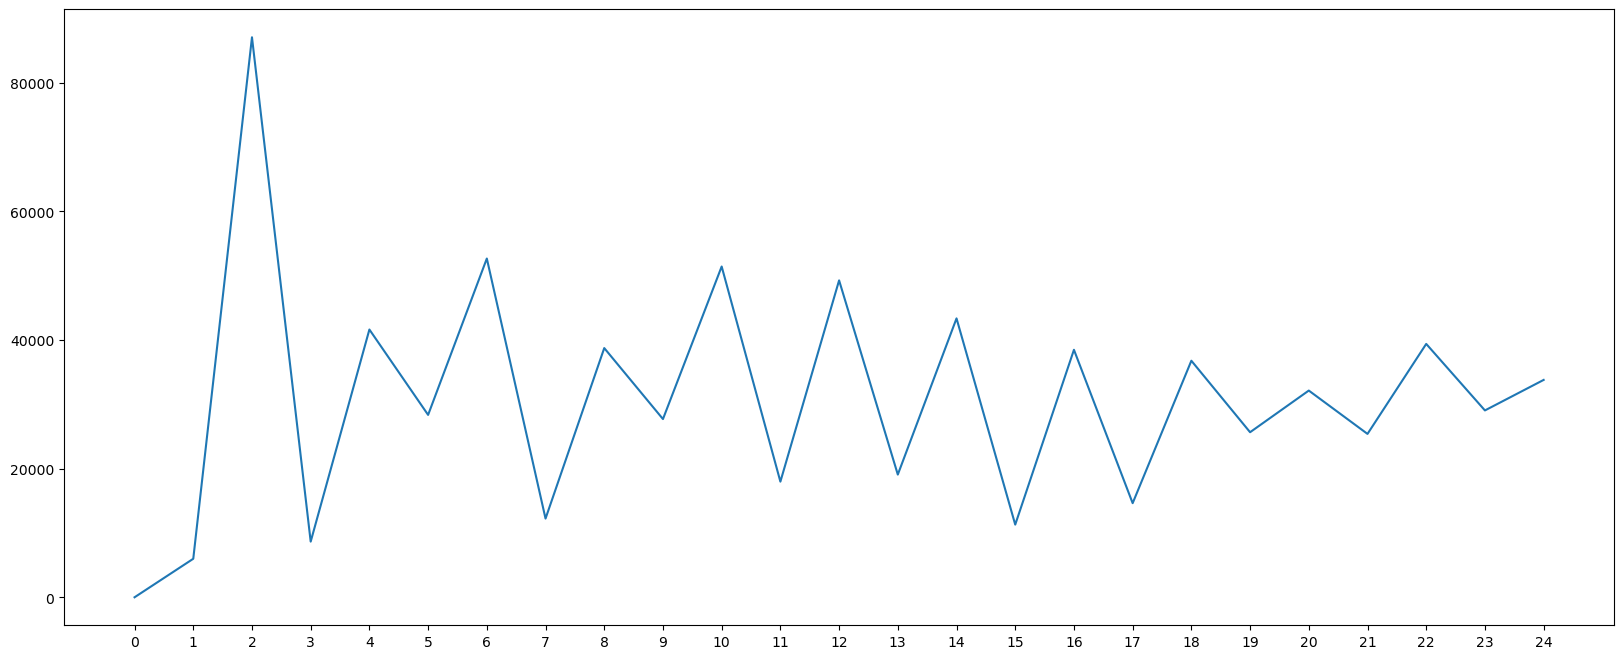

In [15]:
plt.figure(figsize = (20,8))
plt.plot(lags, Norms2)
plt.xticks(lags)
plt.show()